In [1]:
import os
import os.path as op
import sys
import folium

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from myst_nb import glue 

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive
from ind_setup.plotting import plot_bar_probs
from ind_setup.colors import get_df_col
from ind_setup.core import fontsize
from ind_setup.tables import plot_df_table, table_rain_dry_summary


sys.path.append("../../../functions")
from data_downloaders import GHCN
from rain_func import consecutive_dry_days, count_consecutive_days

In [2]:
country = 'Palau'
vars_interest = ['PRCP']

In [3]:
update_data = False
path_data = "../../../data"
path_figs = "../../../matrix_cc/figures"

In [4]:
if update_data:
    df_country = GHCN.get_country_code(country)
    print(f'The GHCN code for {country} is {df_country["Code"].values[0]}')

    df_stations = GHCN.download_stations_info()
    df_country_stations = df_stations[df_stations['ID'].str.startswith(df_country.Code.values[0])]
    print(f'There are {df_country_stations.shape[0]} stations in {country}')

In [5]:
if update_data:
    GHCND_dir = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    id = 'PSW00040309' # Koror Station
    dict_prcp = GHCN.extract_dict_data_var(GHCND_dir, 'PRCP', df_country_stations.loc[df_country_stations['ID'] == id])[0]
    data = dict_prcp[0]['data']#.dropna()
    data.to_pickle(op.join(path_data, 'GHCN_precipitation.pkl'))
else:
    data = pd.read_pickle(op.join(path_data, 'GHCN_precipitation.pkl'))

In [6]:
data['wet_day'] = np.where(data['PRCP'] > 1, 1, np.where((np.isnan(data['PRCP'])==True), np.nan, 0))

Text(0, 0.5, 'Number of Days')

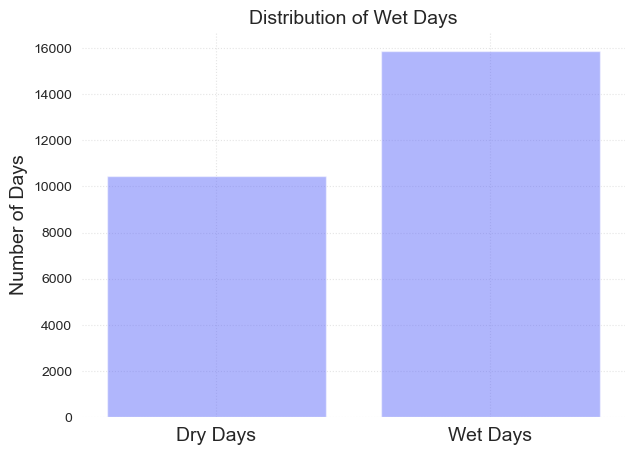

In [7]:
fig, ax = plot_bar_probs(x = [0, 1], y = data.groupby('wet_day').count()['PRCP'].values, labels = ['Dry Days', 'Wet Days'])
ax.set_title('Distribution of Wet Days', fontsize = fontsize)
ax.set_ylabel('Number of Days', fontsize = fontsize)    

In [8]:
threshold = 1 #np.percentile(data['PRCP'].dropna(), 90)
data['wet_day_t'] = np.where(data['PRCP'] > threshold, 1, np.where((np.isnan(data['PRCP'])==True), np.nan, 0))

In [9]:
data_th = data.groupby([data.index.year, data.wet_day_t]).count()['PRCP']
data_th = data_th/data.groupby(data.index.year).count()['PRCP'] * 365

Text(0, 0.5, 'Number of days')

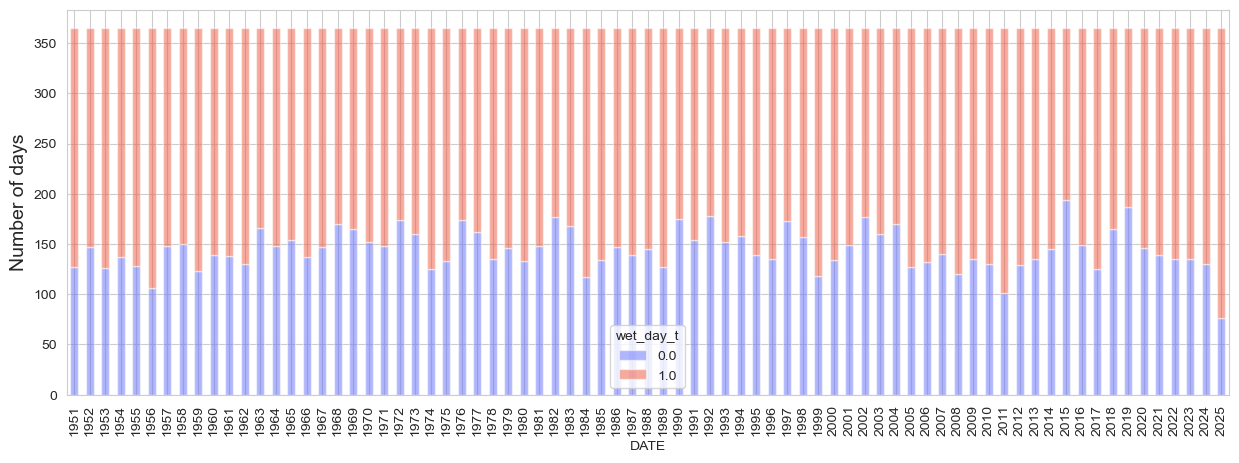

In [10]:
fig, ax = plt.subplots(figsize = [15, 5])
data_th.unstack().plot(kind = 'bar', stacked = True, ax = ax, color = get_df_col()[:2], edgecolor = 'white', alpha = .5)
ax.set_ylabel('Number of days', fontsize = fontsize)

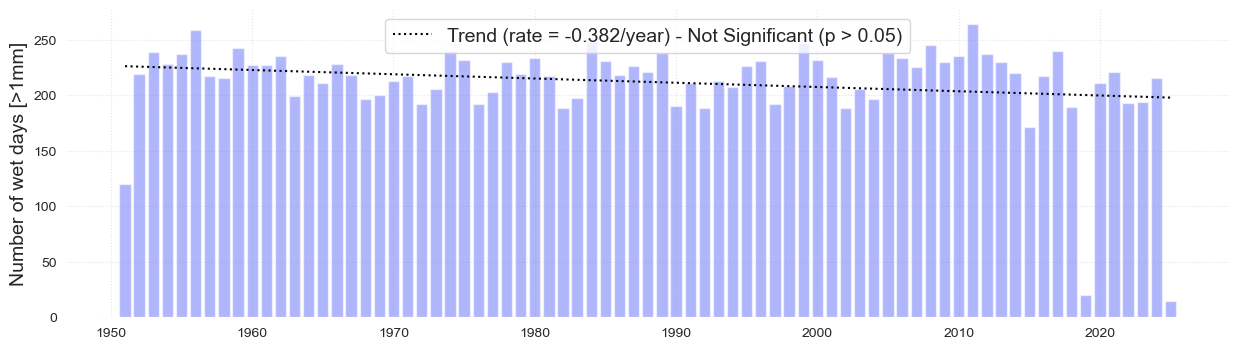

In [11]:
#Wet days
data2 = data.loc[data['wet_day_t'] == 1]
data2 = data2.groupby(data2.index.year).count()
fig, ax, trend = plot_bar_probs(x = data2.index, y = data2.PRCP.values, trendline = True,
               y_label = 'Number of wet days [>1mm]', figsize = [15, 4], return_trend = True)
plt.savefig(op.join(path_figs, 'F7a_Wet_days_1mm.png'), dpi=300, bbox_inches='tight')
glue("trend_wet", float(trend), display=False)


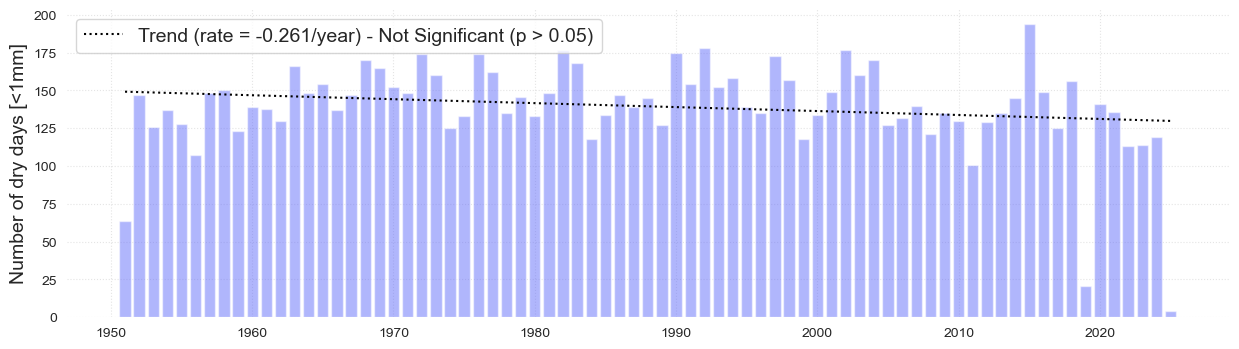

In [12]:
#Dry days
data2 = data.loc[data['wet_day_t'] == 0]
data2 = data2.groupby(data2.index.year).count()
fig, ax, trend = plot_bar_probs(x = data2.index, y = data2.PRCP.values, trendline = True,
               y_label = 'Number of dry days [<1mm]', figsize = [15, 4], return_trend = True)
plt.savefig(op.join(path_figs, 'F6a_Number_dry.png'), dpi=300, bbox_inches='tight')

glue('trend_dry', float(trend), display=False)


In [13]:
threshold = 1 #Threshold for dry and wet day
data = data.groupby(data.index.year).filter(lambda x: len(x) >= 300).dropna()
data['dry_day'] = np.where(data['PRCP'] < threshold, 1, 0)

In [14]:
consecutive_dry_year = data.groupby(data.index.year)['dry_day'].apply(consecutive_dry_days)
data['below_threshold'] = data['PRCP'] < threshold
data['consecutive_days'] = count_consecutive_days(data['below_threshold'])

(<Figure size 1200x500 with 1 Axes>,
 <Axes: ylabel='Mean consecutive dry days [< 1mm]'>)

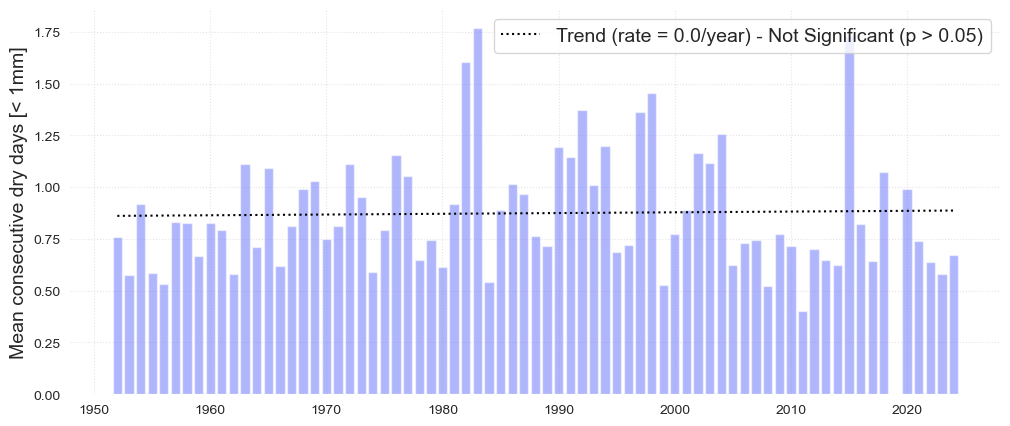

In [15]:
plot_bar_probs(np.unique(data.index.year), data.groupby(data.index.year)['consecutive_days'].mean(), 
               trendline =True, y_label = 'Mean consecutive dry days [< 1mm]',
               figsize = [12, 5])


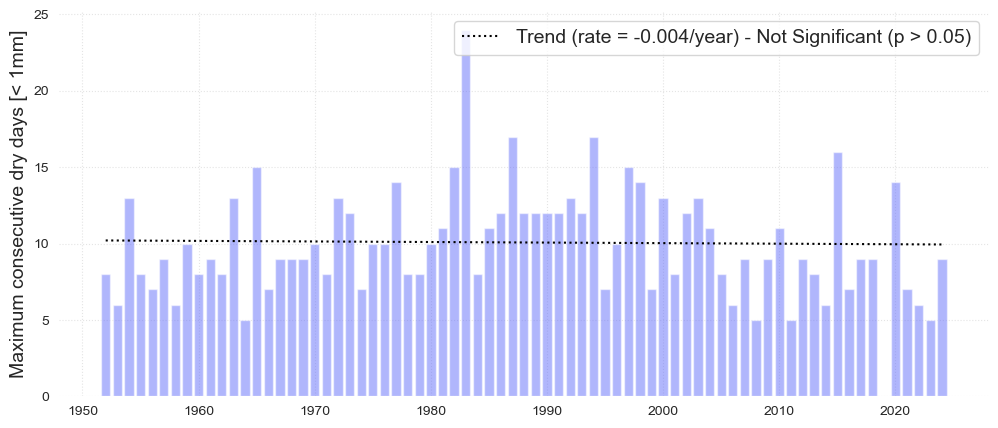

In [16]:
fig = plot_bar_probs(np.unique(data.index.year), data.groupby(data.index.year)['consecutive_days'].max(), 
               trendline =True, y_label = 'Maximum consecutive dry days [< 1mm]',
               figsize = [12, 5])

plt.savefig(op.join(path_figs, 'F6b_Consecutive_dry.png'), dpi=300, bbox_inches='tight')


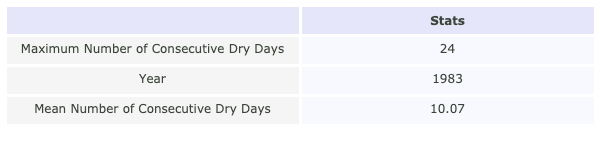

In [17]:
df = table_rain_dry_summary(data)
fig = plot_df_table(df.T, figsize = (600, 150),)